# Clustering of People's Biographies on Wikipedia

## Introduction

Clustering is a unsupervised machine learning task used to define hidden structure from unlabeled data. Unlike supervised machine learning there is no labeled data to guide the learner in finding patterns. In this project I am going to introduce K-Mean which is one the most widely used Clustering teckniques. I am also going to introduce a set of guidelines to find out optimal no of K clusters.

I will clustering biographies of famous peolple which I will web scrape from wikipedia, at the end of this project I will introduce how to do topic modelling and present some latent features present in the wikipedia dataset.  

## Objective


1. Web scrape biograpgies of famous people from the Wikipedia.
+ Apply Nearest Neighbour(NN) algo to find the closest people to each other, also compare results by using differewnt distance metrics available in NN algo.
+ Compare the Neighbour(NN) results by implementing count vectorization and tf-idf vectorization.
+ Implement K-Mean clustering algo and exhibits K-Mean's pros and cons.
+ Compare K-mean results with other available advance clustering algo like Agglomerative clustering, etc
+ Intro to **Topic Modelling** by using  generative statistical model like latent Dirichlet allocation (LDA).
---

In [1]:
import pandas as pd
import string
import requests
from bs4 import BeautifulSoup
import numpy as np
from stop_words import get_stop_words
from nltk.stem import *
from prettytable import *

In [2]:
import pickle

#wiki.to_pickle("wikiprocessed")

#pickle.dump(tf_idf, open("tfidf.pickle", "wb"))
#pickle.dump(word_count, open("wc.pickle", "wb"))

#tf_idf = pickle.load(open("tfidf.pickle", "rb"))
#word_count = pickle.load(open("wc.pickle", "rb"))


#wiki = pd.read_pickle("wikiprocessed")

In [3]:
# Create a function that prints Panda dataframe as more Web Friendly

def print_df(df,cols='all',f=0,l=5,label = ""):
    '''Function for printing
       dataframe into PrettyTable
    '''
    if len(cols) == 0:
        print("specify cols to be printed")
        return
    elif cols == "all":
        columns = df.columns
    else:
        columns = cols
        
    df = df.iloc[f:l,:]
    df = df.copy()
    
    for c in columns:
        df.loc[:,c] = df.loc[:,c].apply(lambda x: str(x)[:25]+"..." if len(str(x))>=25 else x)

        
    pt1 = PrettyTable()
    pt2 = PrettyTable()
    
    if len(label)!=0:
        pt1.title = label
    
    i = len(columns)/2
    
    for c,i in zip(columns,range(len(columns))):
        if i <=6: 
            pt1.add_column(c, df.loc[:,c].values)
        else:
            pt2.add_column(c, df.loc[:,c].values)
    
    if len(columns)<=7:
        print(pt1)
        
    elif len(columns)>7:
        print(pt1)
        print(pt2)

In [6]:
# Reading in the Pantheon Datasets in Panda Dataframe 
pantheon = pd.read_csv("pantheon.tsv",delimiter="\t")

## Web Scraping Wikipedia

The [Pantheon team](http://pantheon.media.mit.edu/about/team) at MIT Media Lab maintan's the [datasets](http://pantheon.media.mit.edu/about/datasets)[1] of famous people who have biography on Wikipedia. I am going to use the same dataset to web scrape people's biographies.

In the dataset, variable curid is provided which can be used to access individual's wikipedia page, for eg Abraham Lincoln curid is 307 which can be used in URL https://en.wikipedia.org/wiki?curid=307 to acces Abraham Lincoln's wikipedia

In [7]:
print_df(pantheon,cols = ["en_curid","name","gender","birthyear","countryName","occupation","industry"],label="Pantheon Dataset")

+------------------------------------------------------------------------------------------------------+
|                                           Pantheon Dataset                                           |
+----------+-----------------+--------+-----------+----------------+---------------+-------------------+
| en_curid |       name      | gender | birthyear |  countryName   |   occupation  |      industry     |
+----------+-----------------+--------+-----------+----------------+---------------+-------------------+
|   307    | Abraham Lincoln |  Male  |    1809   | UNITED STATES  |   POLITICIAN  |     GOVERNMENT    |
|   308    |    Aristotle    |  Male  |    -384   |     Greece     |  PHILOSOPHER  |     PHILOSOPHY    |
|   339    |     Ayn Rand    | Female |    1905   |     Russia     |     WRITER    |      LANGUAGE     |
|   595    |   Andre Agassi  |  Male  |    1970   | UNITED STATES  | TENNIS PLAYER | INDIVIDUAL SPORTS |
|   628    |  Aldous Huxley  |  Male  |    1894   | UNI

Checking the top 10 occupation present in the pantheon dataset by count. I will be be using only top 10 categories for for illustrating fiefferent clustering techniques.

In [8]:
# checking the Top 10 categories present in the dataset
pantheon_occp_count = (pd.DataFrame(pantheon.occupation.value_counts(dropna=False)).reset_index()
                        .rename(columns = {"index":"Occupation","occupation":"Count"}))

print_df(pantheon_occp_count,cols="all",f=0,l=15)

+--------------------+-------+
|     Occupation     | Count |
+--------------------+-------+
|     POLITICIAN     |  2530 |
|       ACTOR        |  1193 |
|   SOCCER PLAYER    |  1064 |
|       WRITER       |  954  |
|  RELIGIOUS FIGURE  |  518  |
|       SINGER       |  437  |
|      MUSICIAN      |  381  |
|    PHILOSOPHER     |  281  |
|     PHYSICIST      |  268  |
|      COMPOSER      |  225  |
| MILITARY PERSONNEL |  224  |
|      CHEMIST       |  220  |
|      PAINTER       |  178  |
|   FILM DIRECTOR    |  177  |
|   TENNIS PLAYER    |  161  |
+--------------------+-------+


Below two functions are used for downloading wikipedia content.

In [9]:
from time import sleep

# Use en_curid to scarpe the content from wikipedia.
def downloadContent(curid):
    ''' For downloading the text usinf en_curid
    '''
    link = 'https://en.wikipedia.org/?curid=' + curid
    page = requests.get(link)
    content = page.text
    soup = BeautifulSoup(content,"lxml")
    subsup = soup.find("div", {"id": "mw-content-text"})
    paras = subsup.find_all("p")
    return paras


def biography(curid):
    doc = ""
    sleep(2)
    paras = downloadContent(curid)
    for p in paras:
        txt = p.text
        if txt[:72] == "* Senior club appearances and goals counted for the domestic league only":
            txt = " "
        doc = doc + txt
    return doc

In [10]:
wiki.loc[:,"text"] = wiki.en_curid.apply(lambda x: biography(str(x)))

After downloading the text, variable text_length is created and any article having less than 100 words are removed

In [68]:
wiki.loc[:,"text_length"] = wiki.text.apply(lambda x: len(x.split()))
wiki=wiki.loc[wiki.text_length>100,:].reset_index(drop=True)

In [79]:
print_df(wiki)

+----------+-----------------+--------+-----------+----------------+---------------+-------------------+
| en_curid |       name      | gender | birthyear |  countryName   |   occupation  |      industry     |
+----------+-----------------+--------+-----------+----------------+---------------+-------------------+
|   307    | Abraham Lincoln |  Male  |    1809   | UNITED STATES  |   POLITICIAN  |     GOVERNMENT    |
|   308    |    Aristotle    |  Male  |    -384   |     Greece     |  PHILOSOPHER  |     PHILOSOPHY    |
|   339    |     Ayn Rand    | Female |    1905   |     Russia     |     WRITER    |      LANGUAGE     |
|   595    |   Andre Agassi  |  Male  |    1970   | UNITED STATES  | TENNIS PLAYER | INDIVIDUAL SPORTS |
|   628    |  Aldous Huxley  |  Male  |    1894   | UNITED KINGDOM |     WRITER    |      LANGUAGE     |
+----------+-----------------+--------+-----------+----------------+---------------+-------------------+
+------------------------------+-------------+
|       

## k-Nearest Neighbour Algo

The task at hand is to find out the top 10 closest wikipedia article to the given wikipedia article. To achieve this we need to convert textual data into count vector i.e calulate the frequency of each word present in the article.

In [12]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize,sent_tokenize          
from nltk.stem import WordNetLemmatizer
import re

In [16]:
class LemmaTokenizer(object):
       def __init__(self):
            self.wnl = WordNetLemmatizer()
       def __call__(self, doc):
            tokens = [word for sen in sent_tokenize(doc) for word in word_tokenize(sen)]
            filtered_tokens = []
            for token in tokens:
                if re.search('^[a-zA-Z]*$', token):
                    filtered_tokens.append(token)           
            return [self.wnl.lemmatize(t) for t in filtered_tokens]

In [17]:
vectorizer = CountVectorizer(strip_accents='ascii',
                              tokenizer=LemmaTokenizer(),
                              lowercase=True,
                              min_df = 3)


word_count = vectorizer.fit_transform(wiki.text)

**min_df** = 3 means ignore terms that appear in less than 3 documents i.e words that are unique to only two wikipedia article will not be considered in creation of vocabulary
 
**lowercase** = True will convert all the tokens i.e words into lowercase
 
**strip_accents** = ascii  remove accents during the preprocessing step
 
**tokenizer** = LemmaTokenizer() implements customizied token level analysis for removing punctuation, lemmatizing the word and removing numbers from the document  

The count vector process also builds vocabulary which can be used to find out specific count of a word, which in return can be used to create a dictionary of the count vector. The below code does exactly that.

In [83]:
word_to_index = pd.DataFrame(list(vectorizer.vocabulary_.items()),columns=["word","index"])
word_to_index = word_to_index.set_index("index")
word_to_index.index.name = None

def word_dict(matrix, map_index_to_word):
    ''' function for creating word count dictionary
    '''    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([word_to_index.loc[word_id,"word"] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

In [88]:
wiki.loc[:,"word_count"] = word_dict(word_count, word_to_index)

In [91]:
print_df(wiki,f=1376,l=1381)

+----------+-------------------+--------+-----------+---------------+-----------------+------------------+
| en_curid |        name       | gender | birthyear |  countryName  |    occupation   |     industry     |
+----------+-------------------+--------+-----------+---------------+-----------------+------------------+
|  27773   | Sophia of Hanover | Female |    1630   |  NETHERLANDS  |     NOBLEMAN    |    GOVERNMENT    |
|  27784   |       Sappho      | Female |    -625   |     Greece    |      WRITER     |     LANGUAGE     |
|  27786   |  Simon bar Kokhba |  Male  |    100    |    Unknown    | SOCIAL ACTIVIST |     ACTIVISM     |
|  27791   |   Sophie Germain  | Female |    1776   |     FRANCE    |  MATHEMATICIAN  |       MATH       |
|  741705  |    Mark Harmon    |  Male  |    1951   | UNITED STATES |      ACTOR      | FILM AND THEATRE |
+----------+-------------------+--------+-----------+---------------+-----------------+------------------+
+------------------------------+-----

Now word count vector can be used to calculate 10 Nearest Neigbour of a given document. The two most common distance metrics used are Euclidean distance and Cosine Similarity.

**Euclidean Distance:**

In simple term Euclidean Distance is the magnitude between the points in vector space, its not concerned with the dirction of the vectors w.r.t to origin. This makes Euclidean Distance susceptible to the length of the vector i.e total words in the document

**Cosine Similarity**

Whereas in the case of Cosine Similarity not only the magnitude but also the direction of the vectors are taken into consideration. The length of document has no effect in determing the nearest neigbour

In [13]:
# iniatializing 
model_euclidean = NearestNeighbors(metric='euclidean', algorithm='brute')
model_euclidean.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [14]:
model_cosine =  NearestNeighbors(metric='cosine', algorithm='brute')
model_cosine.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [15]:
wiki.loc[wiki.name.str.contains("Trump"),"name"]

8588    Donald Trump
Name: name, dtype: object

### Let's find top 10 Neighbors for Donald Trump

In [16]:
dist_euc, ind_euc = model_euclidean.kneighbors(word_count[8588], n_neighbors=10)
dist_cos, ind_cos = model_cosine.kneighbors(word_count[8588], n_neighbors=10)

In [17]:
def print_NN(df,indices,distances,var="distances",label=""):
    df1 =pd.DataFrame()
    
    df1.loc[:,"names"] = df.loc[indices[0],"name"].values
    df1.loc[:,"occupation"] = df.loc[indices[0],"occupation"].values
    df1.loc[:,"country"] = df.loc[indices[0],"countryName"].values
    df1.loc[:,"text length"] = df.loc[indices[0],"text_length"].values
    df1.loc[:,var] = distances.flatten()[:10]
    print_df(df1,label=label,l=10)

In [18]:
print_NN(wiki,ind_euc,dist_euc,var = "Euclidean Distances",label="Donald Trump Top 10 Neighbors")

+----------------------------------------------------------------------------------------------------+
|                                   Donald Trump Top 10 Neighbors                                    |
+------------------------------+----------------+----------------+-------------+---------------------+
|            names             |   occupation   |    country     | text length | Euclidean Distances |
+------------------------------+----------------+----------------+-------------+---------------------+
|         Donald Trump         | BUSINESSPERSON | UNITED STATES  |    12856    |         0.0         |
|         Barack Obama         |   POLITICIAN   | UNITED STATES  |    11079    |    577.374228729    |
|       Harold Macmillan       |   POLITICIAN   | UNITED KINGDOM |    11525    |    581.123911055    |
|      Alec Douglas-Home       |   POLITICIAN   | United Kingdom |     9555    |    584.498930709    |
|        Clement Attlee        |   POLITICIAN   | United Kingdom |    109

Barack Obama needs no introduction

John McCain and John Adams are american politician

Harold Macmillan, Alec Douglas-Home are british conservative politicians

Clement Attlee is liberal bristish politician

Chinua Achebe, Rudyard Kipling and William Pitt, 1st Earl of Chatham makes no sense why there are on the list.

Let's try Cosine Similarity to find top 10 Donal Trump neighbours


In [76]:
print_NN(wiki,ind_cos,dist_cos,var = "Cosine Similarity",label="Donald Trump Top 10 Neighbors")

+--------------------------------------------------------------------------------------------+
|                               Donald Trump Top 10 Neighbors                                |
+------------------------+-----------------+---------------+-------------+-------------------+
|         names          |    occupation   |    country    | text length | Cosine Similarity |
+------------------------+-----------------+---------------+-------------+-------------------+
|      Donald Trump      |  BUSINESSPERSON | UNITED STATES |    12856    | 2.55351295664e-15 |
|      Bobby Jindal      |    POLITICIAN   | UNITED STATES |     7062    |  0.0938573513681  |
|   Marc Ravalomanana    |    POLITICIAN   |   MADAGASCAR  |     5092    |  0.0950081281146  |
|    Andry Rajoelina     |    POLITICIAN   |   MADAGASCAR  |     4451    |   0.100111554991  |
| Dominique Strauss-Kahn |    ECONOMIST    |     FRANCE    |     3206    |   0.102887137401  |
| Félix Houphouët-Boigny |    POLITICIAN   |  Ivor

Bobby Jindal is american politician and former Lousiana governor who ran for Republician nominee for 2016 presidential election along side Donal Trump 

Franklin D. Roosevelt, Dwight D. Eisenhower, Barack Obama are american presidents

Dominique Strauss-Kahn is french politician who has been in contoveries due to his involvement in several financial and sexual scandals.

Eugène Terre'Blanche was a white supremacist and Afrikaner nationalist

Marc Ravalomanana, Andry Rajoelina, Félix Houphouët-Boigny do not make much sense why there on list

Lets check Why Marc Ravalomanana is on the list  by checking the top most common words with donald trump

In [19]:
def top_words(name,count="word_count"):
    '''Function for accesing the most
       frequent word in wikipedia article
    '''
    word_count_dict = wiki.loc[wiki.name.str.contains(name),count].values[0]
    word_count_df = pd.DataFrame(list(word_count_dict.items()),columns=["word","count"])
    word_count_df = word_count_df.sort_values(by = ['count'],ascending = [False])
    word_count_df = word_count_df.reset_index(drop = True)
    return  word_count_df

def top_common_words(name1,name2,count="word_count"):
    df1 = top_words(name1,count).rename(columns={"count":name1})
    df2 = top_words(name2,count).rename(columns={"count":name2})
    df = df1.merge(df2,on="word",how = "inner")
    return df.sort_values([name1],ascending = [False])

In [20]:
print_df(top_common_words("Donald Trump","Marc Ravalomanana"),l=10,label="Common Words b/w Donald Trump and Marc Ravalomanana")

+------------------------------------------------------+
| Common Words b/w Donald Trump and Marc Ravalomanana  |
+--------+-------------------+-------------------------+
|  word  |    Donald Trump   |    Marc Ravalomanana    |
+--------+-------------------+-------------------------+
|  the   |        767        |           317           |
|   in   |        406        |           174           |
|   a    |        355        |           162           |
|  and   |        355        |           162           |
|   of   |        339        |           187           |
|   to   |        284        |           146           |
|  his   |        222        |            88           |
|   he   |        162        |            63           |
|  for   |        157        |            36           |
|   wa   |        142        |            50           |
+--------+-------------------+-------------------------+


It looks like the common words like a, in, the present in both Donald Trump and Marc Ravalomanana article is influencing the calculation of the nearest neigbour. This issue can be resolved by using TF-IDF technique.

#### Implementing TF-IDF

**From Wikipedia**

>In information retrieval, tf–idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
class LemmaTokenizer(object):
       def __init__(self):
            self.wnl = WordNetLemmatizer()
       def __call__(self, doc):
            tokens = [word for sen in sent_tokenize(doc) for word in word_tokenize(sen)]
            stop_words = get_stop_words('en')
            filtered_tokens = []
            for token in tokens:
                if re.search('^[a-zA-Z]*$', token):
                    if token.lower() not in stop_words:
                        filtered_tokens.append(token)
            filtered_tokens = [self.wnl.lemmatize(t) for t in filtered_tokens]
            return [w for w in filtered_tokens if len(w)>2]

In [81]:
transformer = TfidfVectorizer(smooth_idf=False,
                              strip_accents='ascii',
                              tokenizer=LemmaTokenizer(),
                              lowercase=True,
                              min_df = 3,
                              stop_words = 'english')
tf_idf=transformer.fit_transform(wiki.text)

Save the weights of words in wiki dataframe

In [84]:
word_to_index = pd.DataFrame(list(transformer.vocabulary_.items()),columns=["word","index"])
word_to_index = word_to_index.set_index("index")
word_to_index.index.name = None

wiki.loc[:,"word_weight"] = word_dict(tf_idf , word_to_index)

In [4]:
print_df(wiki,f=1376,l=1381)

+----------+-------------------+--------+-----------+---------------+-----------------+------------------+
| en_curid |        name       | gender | birthyear |  countryName  |    occupation   |     industry     |
+----------+-------------------+--------+-----------+---------------+-----------------+------------------+
|  27773   | Sophia of Hanover | Female |    1630   |  NETHERLANDS  |     NOBLEMAN    |    GOVERNMENT    |
|  27784   |       Sappho      | Female |    -625   |     Greece    |      WRITER     |     LANGUAGE     |
|  27786   |  Simon bar Kokhba |  Male  |    100    |    Unknown    | SOCIAL ACTIVIST |     ACTIVISM     |
|  27791   |   Sophie Germain  | Female |    1776   |     FRANCE    |  MATHEMATICIAN  |       MATH       |
|  741705  |    Mark Harmon    |  Male  |    1951   | UNITED STATES |      ACTOR      | FILM AND THEATRE |
+----------+-------------------+--------+-----------+---------------+-----------------+------------------+
+------------------------------+-----

In [21]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [22]:
dist, ind = model_tf_idf.kneighbors(tf_idf[8588], n_neighbors=10)

In [23]:
print_NN(wiki,ind,dist,var = "Euclidean Distances",label="Donald Trump Top 10 Neighbors")

+---------------------------------------------------------------------------------------------+
|                                Donald Trump Top 10 Neighbors                                |
+------------------------+----------------+---------------+-------------+---------------------+
|         names          |   occupation   |    country    | text length | Euclidean Distances |
+------------------------+----------------+---------------+-------------+---------------------+
|      Donald Trump      | BUSINESSPERSON | UNITED STATES |    12856    |         0.0         |
|      Vicente Fox       |   POLITICIAN   |     Mexico    |     3353    |    1.14319407794    |
|       Paul Ryan        |   POLITICIAN   | United States |     3548    |    1.26871272913    |
|    Robert Kiyosaki     | BUSINESSPERSON | UNITED STATES |     535     |     1.3011294405    |
| Hillary Rodham Clinton |   POLITICIAN   | UNITED STATES |    16501    |    1.31922399352    |
|     Dayana Mendoza     |     MODEL    

Vicente Fox, Enrique Peña Nieto are Mexico president and former president who have been in conflict with Donal Trump regarding the wall on mexican border

Paul Ryan is a american politician and Speaker of the United States House of Representatives.

Hillary Rodham Clinton is american politician from democratic party who ran against Trump in 2016 presidential election

Rosie O'Donnell, she has been strong critic of Trump for years.

Marine Le Pen is a French politician who is a leader of Conservative Nationalist party.

Dayana Mendoza and Robert Kiyosaki have been associated with Trump.

***The tf-df result makes more sense then the other list***


***Top common words between Donald Trump and Ron Paul***



In [24]:
print_df(top_common_words("Ron Paul","Donald Trump",count= "word_weight"),l=20,label="Common Words b/w Ron Paul and Donald Trump ")

+-----------------------------------------------------+
|     Common Words b/w Ron Paul and Donald Trump      |
+---------------+-----------------+-------------------+
|      word     |     Ron Paul    |    Donald Trump   |
+---------------+-----------------+-------------------+
|      paul     |  0.679277310395 | 0.000975387809153 |
|   republican  |  0.265371524048 |  0.0507934545587  |
|      vote     |  0.176347141289 |  0.0131208133764  |
|     party     |  0.163386676895 |  0.0209976112101  |
|    election   |  0.112378839674 |   0.027814891707  |
|  presidential |  0.110519871095 |   0.036154217486  |
|    primary    |  0.110189079831 |  0.0141609310003  |
|    federal    |  0.107892127721 |  0.0145955143027  |
|   convention  | 0.0950641572055 |  0.0114984979966  |
|    campaign   | 0.0946999101014 |  0.0373803391108  |
|    liberty    | 0.0891657887966 |  0.00152788350676 |
|     romney    | 0.0869944814704 |  0.00496892493603 |
|   candidate   | 0.0868509916488 |  0.016448733

## K-Means Clustering

I will be implementing K-mean clustering thrice to better understand how K-means works. First we will implement on only first three categories then we will implement on top 10 categories and after that finnaly we will implement on all categories

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
wiki3 = pd.read_pickle("wiki_10.p")

In [98]:
wiki3 = wiki3.loc[wiki3.occupation.isin(["POLITICIAN","ACTOR","SOCCER PLAYER"]),:]

In [99]:
tf_idf3=transformer.fit_transform(wiki3.text)

In [100]:
km = KMeans(n_clusters=3,n_jobs=4)
km.fit(tf_idf3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [101]:
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
svd.fit(tf_idf3.T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=7,
       random_state=42, tol=0.0)

In [102]:
df = pd.DataFrame(columns=["label","comp1","comp2"])
df =df.assign(comp1 = svd.components_[1],
              comp2 = svd.components_[2],
              label = km.labels_,
              length = wiki3.text_length)

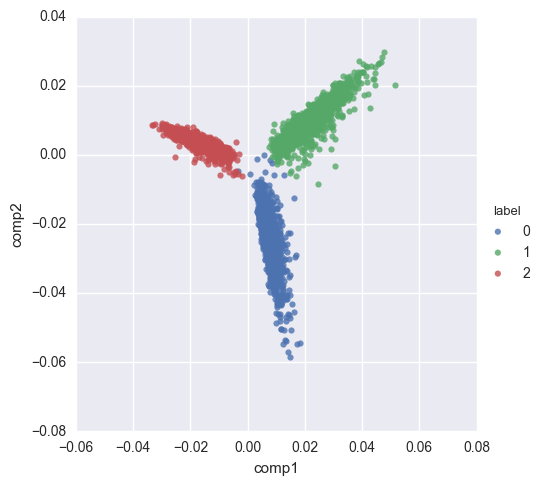

In [103]:
sns.lmplot("comp1", "comp2", 
           data=df.loc[df.length>25,:], 
           fit_reg=False, 
           hue="label",  
           )

Now Implementing K-means on top 10 categories

In [104]:
wiki10 = pd.read_pickle("wiki_10.p")

In [105]:
tf_idf10=transformer.fit_transform(wiki10.text)

#### How to select which K to select?

+ Select a metric that tells you that how better defined clusters are, I am using Silhouette Coefficient.
+ Calculate metric for a range of K in this case 3 to 10
+ Then, plot the metrics against the K
+ Select the K according elbow method i.e adding another cluster doesn't give much better modeling of the data

In [106]:
from sklearn import metrics

In [107]:
clus = [3,4,5,6,7,8,9,10]
score = []
for k in clus:
    km = KMeans(n_clusters=k,n_jobs=7)
    km.fit(tf_idf10)
    labels = km.labels_
    m = metrics.silhouette_score(tf_idf10, labels,metric='cosine')
    score.append(m)
    print(k,m)

3 0.0302529667154
4 0.0313673762288
5 0.0348271928757
6 0.0383514393731
7 0.0391496813368
8 0.0250304447384
9 0.0241686149365
10 0.0248154642234


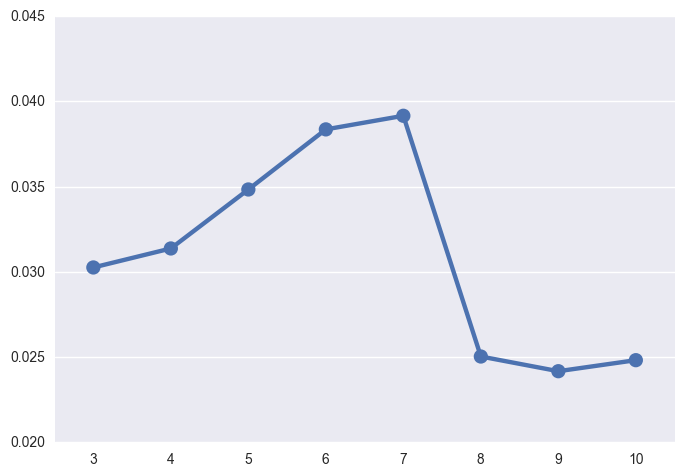

In [111]:
sns.pointplot(x=clus, y=score,);


In [119]:
km = KMeans(n_clusters=7,n_jobs=7)
km.fit(tf_idf10)
labels7 = km.labels_

km = KMeans(n_clusters=6,n_jobs=7)
km.fit(tf_idf10)
labels6 = km.labels_

In [115]:
def heatMap(label):
    hm = wiki10.loc[:,("occupation","name")].assign(Cluster =label)
    hm = hm.groupby(["Cluster", "occupation"]).size().reset_index(drop = False)
    hm.loc[:,0] = hm.loc[:,0].apply(lambda x: int(x))
    hm = hm.rename(columns={"occupation":"Occupation",0:"N"})
    hm = hm.pivot( "Occupation","Cluster", "N")
    hm = hm.fillna(0)
    hm = hm.applymap(int)
    ax = sns.heatmap(hm,cmap="YlGnBu",cbar=False,annot=True,fmt="d",linewidths=.5)

We can now plot these cluster against the categories.

As its clear from below Heatmap that K=6 is optimal

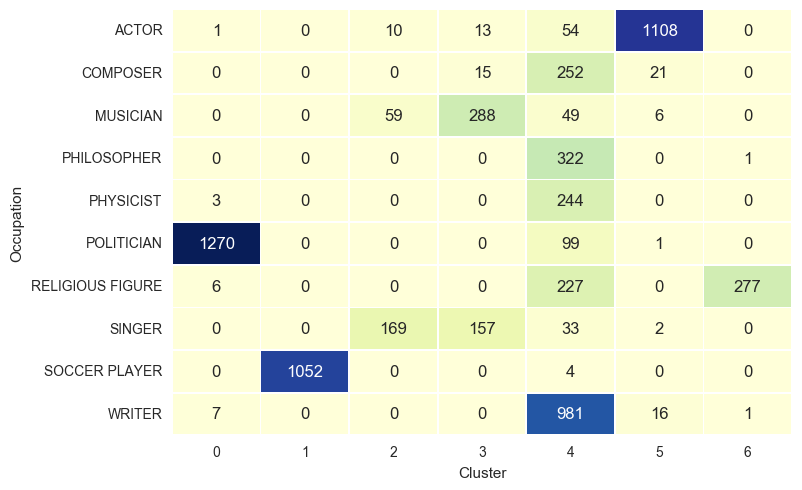

In [116]:
heatMap(labels7)

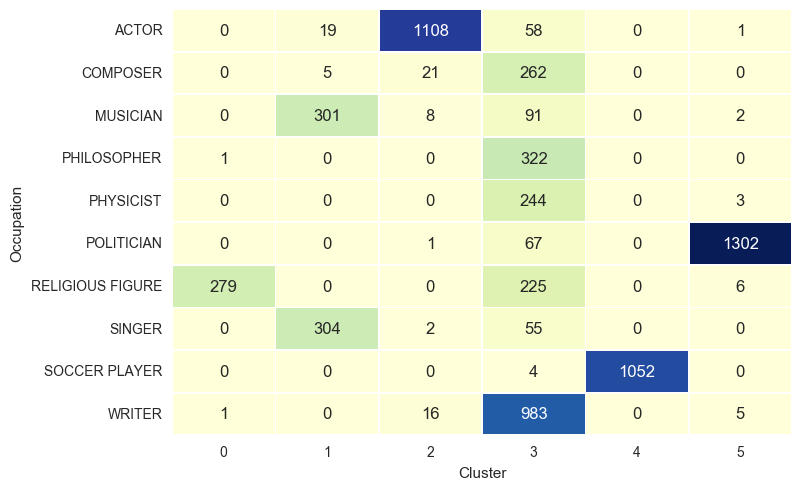

In [117]:
heatMap(labels6)

Try kmean with all categories

In [120]:
clus = [10,11,12,13,14,15,16,17,18,19,20,25,30,40]
score = []
for k in clus:
    km = KMeans(n_clusters=k,n_jobs=7)
    km.fit(tf_idf)
    labels = km.labels_
    m = metrics.silhouette_score(tf_idf, labels,metric='cosine')
    score.append(m)
    print(k,m)

10 0.017767124761
11 0.023644697542
12 0.0252567116126
13 0.0166558906749
14 0.0199963334461
15 0.0250693159291
16 0.0263901702703
17 0.0181711703345
18 0.026661599787
19 0.0230633596687
20 0.0180492643634
25 0.018446743392
30 0.0203305783102
40 0.0196376685802


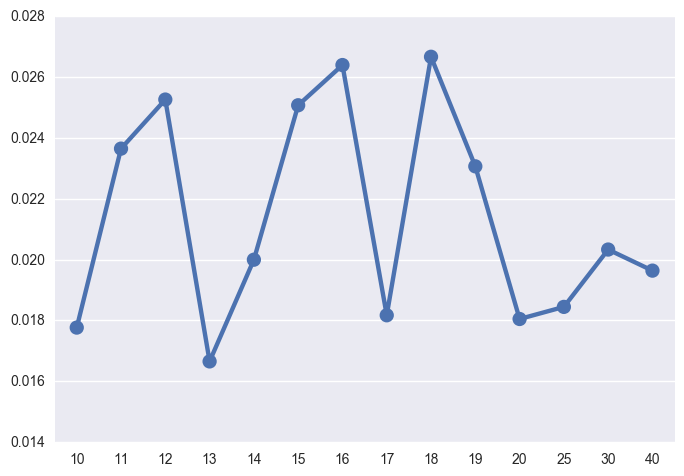

In [121]:
sns.pointplot(x=clus, y=score,);

In [8]:
km = KMeans(n_clusters=18,n_jobs=7)
km.fit(tf_idf)
labels18 = km.labels_

km = KMeans(n_clusters=16,n_jobs=7)
km.fit(tf_idf)
labels16 = km.labels_

km = KMeans(n_clusters=15,n_jobs=7)
km.fit(tf_idf)
labels15 = km.labels_

In [10]:
def vis_kmean(label,tol):
    hm = wiki.loc[:,("occupation","name")].assign(Cluster =label)
    hm = hm.groupby(["Cluster", "occupation"]).size().reset_index(drop = False)
    hm.loc[:,0] = hm.loc[:,0].apply(lambda x: int(x))
    hm = hm.rename(columns={"occupation":"Occupation",0:"N"})
    hm1 = hm.groupby(["Cluster"]).sum().reset_index().rename(columns = {'N':'Sum'})
    hm = pd.merge(hm,hm1,on="Cluster",how="left")
    hm = hm.assign(percentage = hm.N/hm.Sum)
    g = sns.FacetGrid(hm.loc[hm.percentage>tol,:], col="Cluster",col_wrap = 5,sharex = False,sharey = True)
    for ax in g.axes.flatten():
        for t in ax.get_xticklabels():
            t.set(rotation=60)            
    return g.map(sns.barplot,"Occupation", "percentage",palette="RdBu_r")

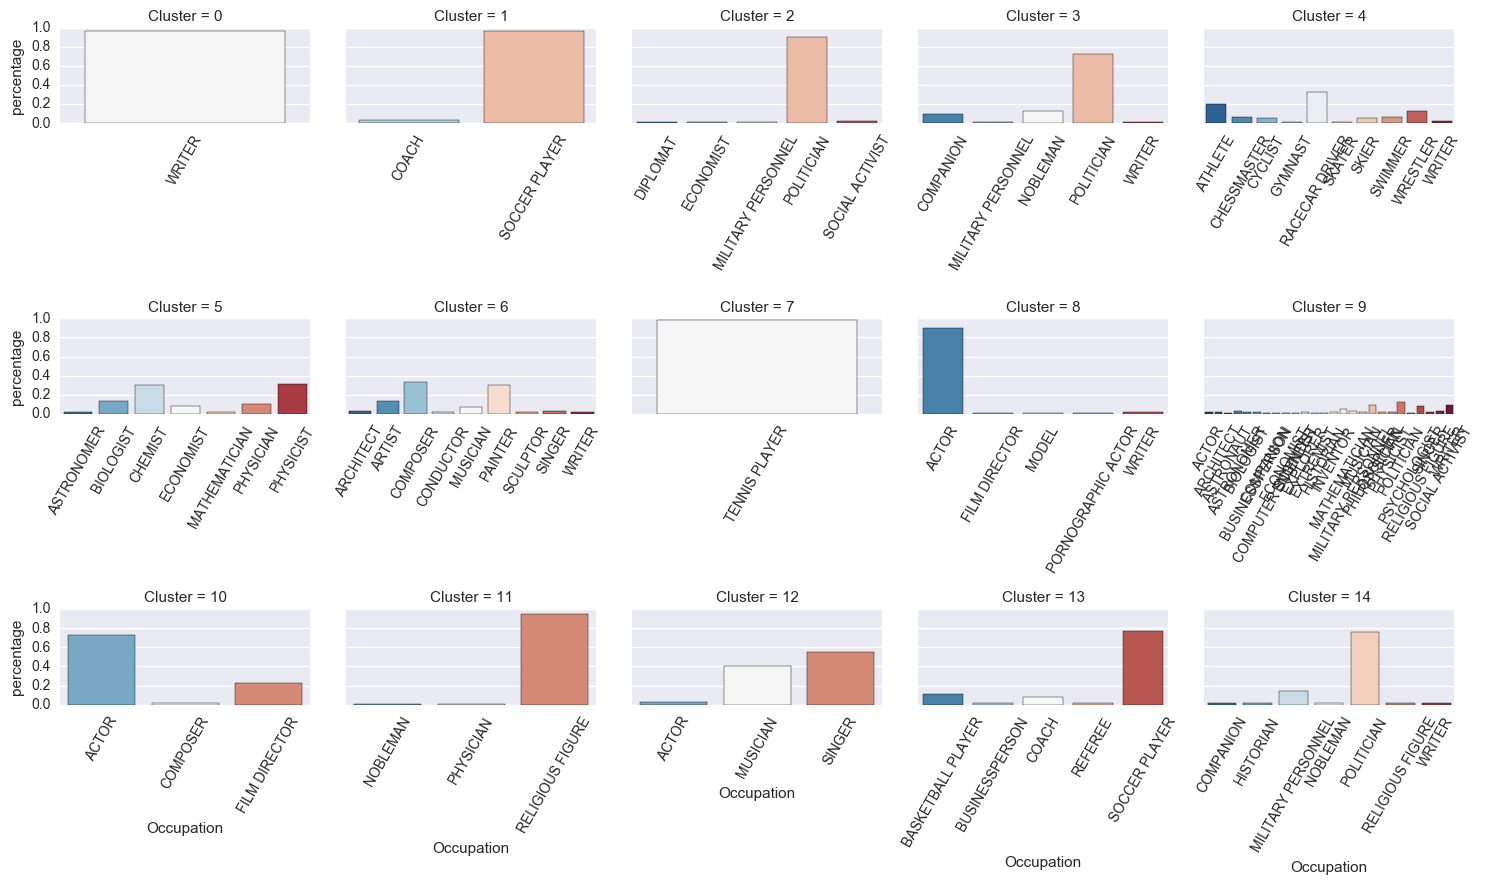

In [11]:
vis_kmean(labels15,0.01)

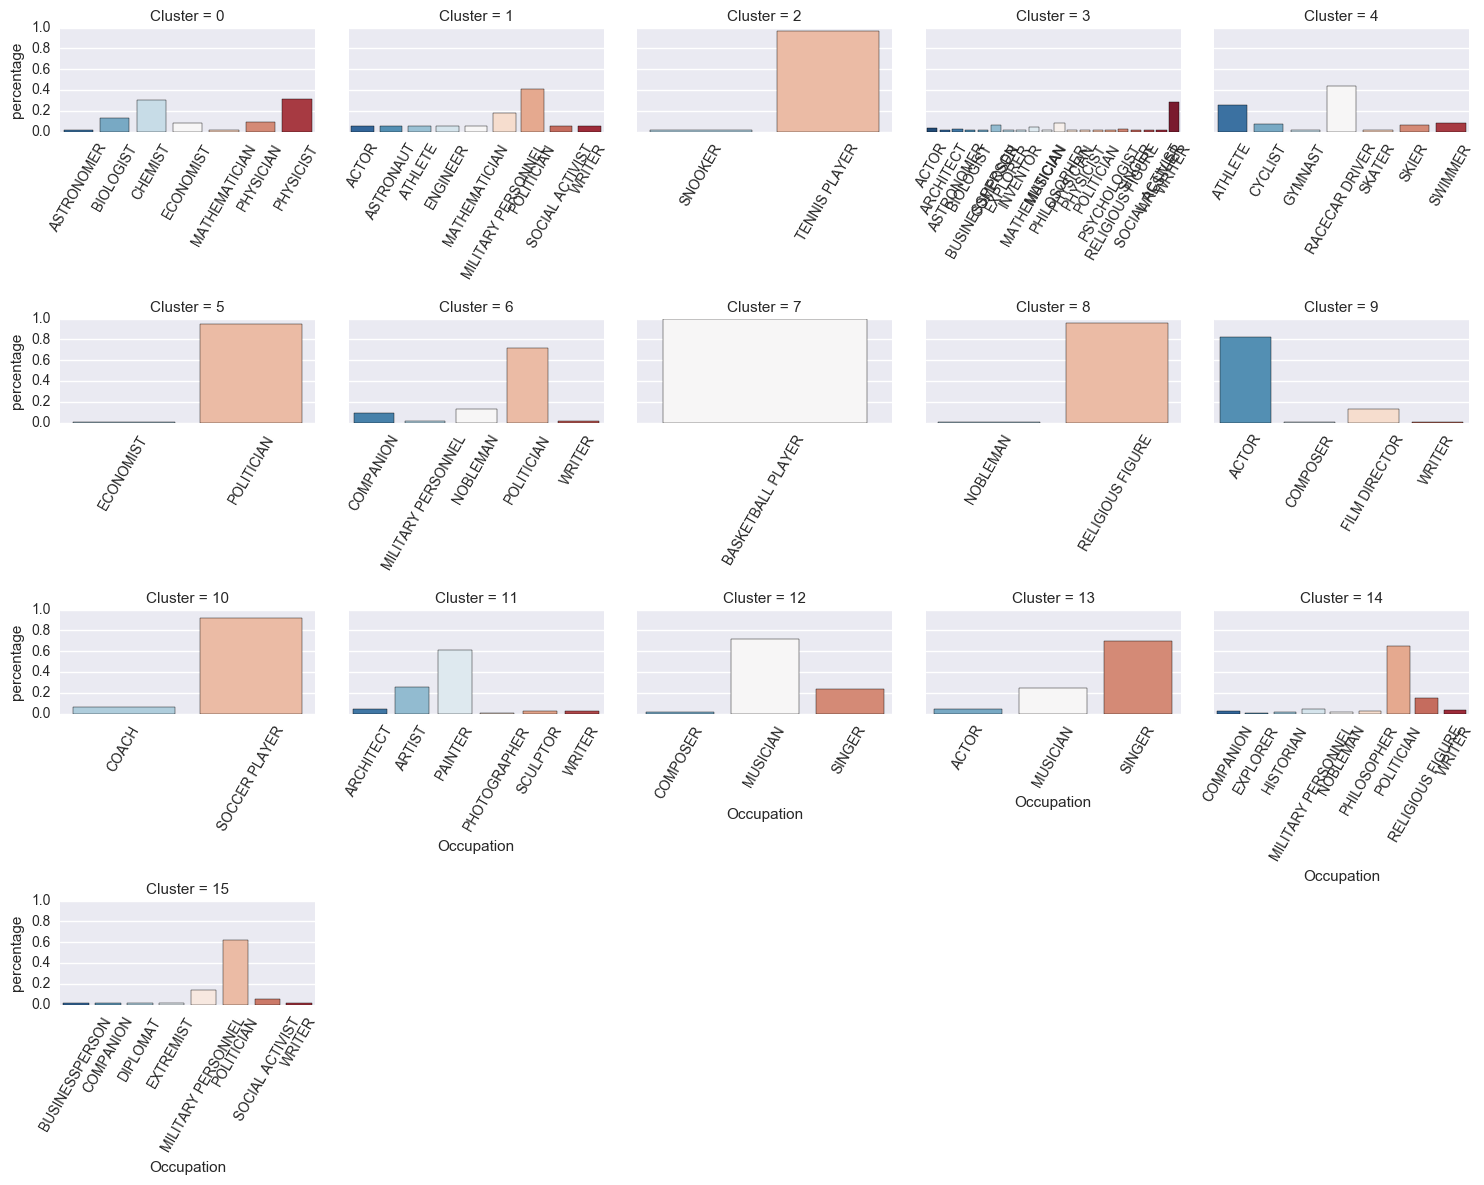

In [160]:
vis_kmean(labels16,0.01)

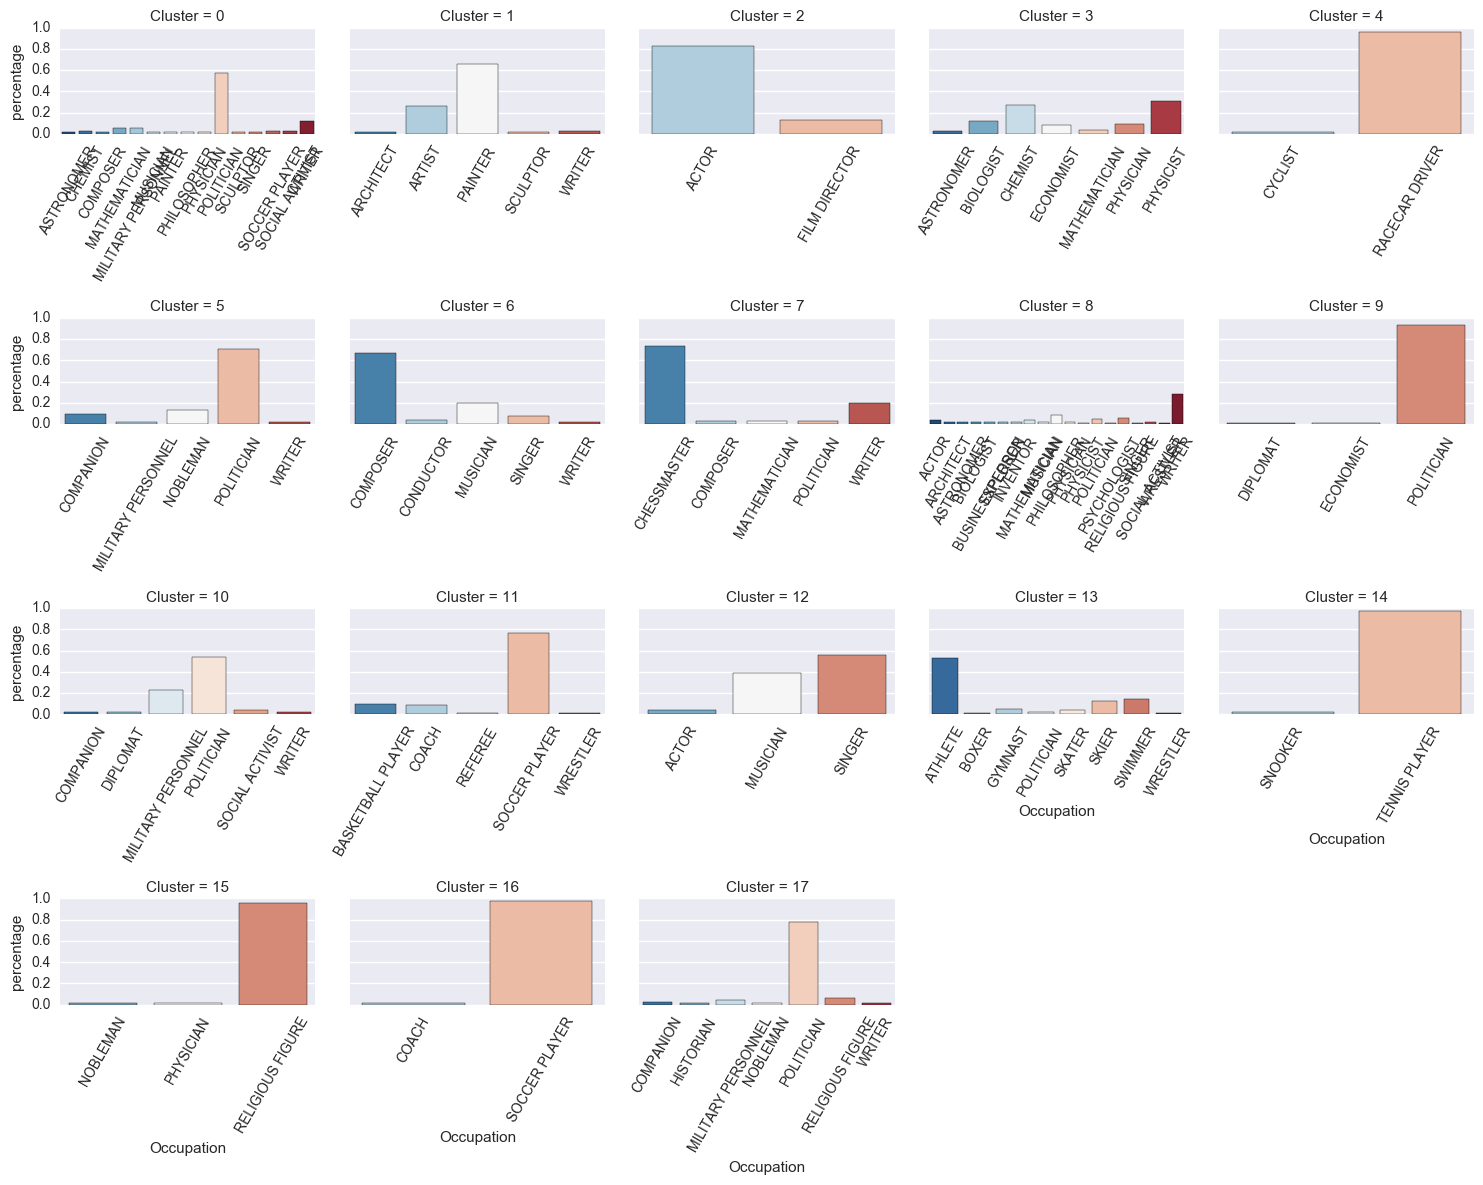

In [13]:
vis_kmean(labels18,0.01)

## Topic Modelling

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [19]:
class LemmaTokenizer(object):
       def __init__(self):
            self.wnl = WordNetLemmatizer()
       def __call__(self, doc):
            tokens = [word for sen in sent_tokenize(doc) for word in word_tokenize(sen)]
            stop_words = get_stop_words('en')
            filtered_tokens = []
            for token in tokens:
                if re.search('^[a-zA-Z]*$', token):
                    if token.lower() not in stop_words:
                        filtered_tokens.append(token)
            filtered_tokens = [self.wnl.lemmatize(t) for t in filtered_tokens]
            return [w for w in filtered_tokens if len(w)>2]

In [22]:
vectorizer = CountVectorizer( strip_accents='ascii',
                              tokenizer=LemmaTokenizer(),
                              lowercase=True,
                              min_df = 3,
                              stop_words = 'english')


word_count = vectorizer.fit_transform(wiki.text)

In [23]:
lda_wc = LatentDirichletAllocation(n_topics=10, random_state=0,learning_method = 'online',n_jobs=-2)
lda_wc.fit(word_count)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=-2, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [24]:
pyLDAvis.sklearn.prepare(lda_wc, word_count, vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      19.126670        1       1  0.026913 -0.173569
9      17.152209        1       2 -0.019561  0.043151
6      12.783433        1       3  0.226367 -0.065119
8      11.498753        1       4 -0.071196 -0.089402
0      10.566087        1       5 -0.073905  0.136767
2       9.109794        1       6 -0.140775 -0.058703
3       7.067771        1       7 -0.027855  0.159192
5       5.550203        1       8 -0.089835 -0.121724
7       4.768551        1       9 -0.093326  0.099157
4       2.376529        1      10  0.263173  0.070251, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
29019  Default  50295.000000          film  50295.000000  30.0000  30.0000
73264  Default  28667.000000        season  28667.000000  29.0000  29.0000
90373  Default  45985.000000          work  45985.000000  28.0000  28.0000
81240  Default  24231.000000          team  24231.000000  27.0000  27.0000
1905   Default  28550.000000         album  28550.000000  26.0000  26.0000
50942  Default  23697.000000         match  23697.000000  25.0000  25.0000
44165  Default  28344.000000          king  28344.000000  24.0000  24.0000
55263  Default  22778.000000         music  22778.000000  23.0000  23.0000
33079  Default  23193.000000          goal  23193.000000  22.0000  22.0000
64674  Default  23679.000000     president  23679.000000  21.0000  21.0000
19179  Default  16412.000000           cup  16412.000000  20.0000  20.0000
31419  Default  19674.000000          game  19674.000000  19.0000  19.0000
46431  Default  20360.000000        league  20360.000000  18.0000  18.0000
66543  Default   9208.000000          race   9208.000000  17.0000  17.0000
89932  Default  18682.000000           win  18682.000000  16.0000  16.0000
15792  Default  18555.000000          club  18555.000000  15.0000  15.0000
72999  Default  14512.000000        scored  14512.000000  14.0000  14.0000
90273  Default  25667.000000           won  25667.000000  13.0000  13.0000
76825  Default  21959.000000          song  21959.000000  12.0000  12.0000
33565  Default  24907.000000    government  24907.000000  11.0000  11.0000
63173  Default  15206.000000        player  15206.000000  10.0000  10.0000
14116  Default  11423.000000  championship  11423.000000   9.0000   9.0000
60835  Default  22467.000000         party  22467.000000   8.0000   8.0000
4583   Default  17442.000000          army  17442.000000   7.0000   7.0000
73328  Default  34346.000000        second  34346.000000   6.0000   6.0000
5945   Default  24129.000000         award  24129.000000   5.0000   5.0000
88864  Default  30864.000000           war  30864.000000   4.0000   4.0000
15103  Default  11940.000000        church  11940.000000   3.0000   3.0000
90408  Default  41953.000000         world  41953.000000   2.0000   2.0000
10034  Default  20956.000000          book  20956.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
65     Topic10    479.184063         abbas    504.574439   3.6879  -6.6591
128    Topic10    611.418287      abdullah    674.563454   3.6412  -6.4154
24765  Topic10   2399.536272         egypt   3787.453663   3.2831  -5.0482
8948   Topic10    787.101230           bin    947.300902   3.5543  -6.1629
2401   Topic10    736.650133        alonso    880.029416   3.5617  -6.2291
12805  Topic10   2431.186061           car   4172.924459   3.1993  -5.0351
41147  Topic10   1281.820827       islamic   1960.095117   3.3148  -5.6752
4107   Topic10   1279.332944          arab   2204.170474   3.1955  -5.6771
33720  Topic10   3253.458763         grand   9132.480769   2.7074  -4.7437
29110  Topic10   1541.055020        finish   3004.444061   3.0719  -5.4910
4114   Topic10    879.063925        arabic   1270.842576   3.3710  -6.0524
35196  To

### Top 10 topics that can be found in above visualization

topic 1: Music, TV, and film

topic 2: American politics

topic 3: Team sports

topic 4: Science 

topic 5: Greek

topic 6: philosophy and Literature

topic 7: General politics

topic 8: International music

topic 9: Religion

topic 10: Race Car